In [57]:
from collections import OrderedDict
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import time
import scipy.io as io
import random
import os
import pickle
from sklearn.cluster import KMeans

from spatial_diffusion_field import SpatialDiffusionField, AgentField


ACTION_MAP = {
    0:"left",1:"right",2:"up",3:"down", \
    4:"up-left",5:"up-right",6:"down-left",7:"down-right"
}

ACTIONS = ["left", "right", "up", "down", \
            "up-left", "up-right", "down-left", "down-right"]

ACTION_OFFSET = [[-1,0],[1,0],[0,-1],[0,1],[-1,-1],[1,-1],[-1,1],[1,1]]

class BlankFieldEnv(gym.Env):
    def __init__(self, max_num_steps=100):
        metadata = {'render.modes': ['human']}
        super(BlankFieldEnv, self).__init__()
                    
        self.max_num_steps = max_num_steps
        
        # Env Field
        self.size = 10
        self.field = np.ones((10,10), dtype=np.float64) * (-1)
        indices = np.argwhere(self.field == -1)
        self.centroids = KMeans(n_clusters=5, random_state=0).fit(indices).cluster_centers_[:,::-1]
        print(self.centroids)

        # Agent Field related params/variables
        self.num_steps = 0
        self.agent_position = None
        self.agent_trajectory = []

        # Action Space
        self.action_space_map = ACTION_MAP
        self.actions = ACTIONS
        self.action_space = spaces.Discrete(8)

        # Environment Observation space
        # self.observation_space = spaces.Box(low=0, high=255, shape=(self.size, self.size, 1), dtype=np.uint8)    
        self.observation_space = spaces.Box(low=-1, high=1, shape=(100,), dtype=np.float32,)    

    def step(self, action_id):
        assert self.action_space.contains(action_id), "Action is invalid!"
        (next_position, hit_wall, revisit) = self.get_next_position(action_id)

        # Update number of steps
        self.num_steps += 1

        # Get any observations
        observations = {"location": next_position}

        # Update agent variables
        self.field[self.agent_position[1],self.agent_position[0]] = 1
        self.field[next_position[1],next_position[0]] = 0
        self.agent_position = next_position
        self.agent_trajectory.append(self.agent_position)
        self.update_min_distances(self.agent_position)
        # self.total_min_distances = self.total_min_distances - np.sum(self.min_distances)
        # Check for termination criteria
        done = (self.num_steps >= self.max_num_steps)
        reward = self.calculate_step_reward()
        
        # Record field values
        # next_state = np.expand_dims(self.field, axis=-1)
        next_state = self.field.flatten()
        return (next_state, reward, done, observations)

    def reset(self):
        # Reset agent related params
        self.num_steps = 0
        self.agent_position = self.choose_random_start_position()
        self.field = np.ones((10,10), dtype=np.float64) * (-1)
        self.field[self.agent_position[1], self.agent_position[0]]=0
        self.agent_trajectory = []
        self.min_distances = None
        # self.total_min_distances = 0
        self.update_min_distances(self.agent_position)
        return self.field.flatten()
    
    def update_min_distances(self, pos):
        distances = np.linalg.norm(self.centroids-pos, axis=1)
        if self.min_distances is None:
            self.min_distances = distances
        else:
            self.min_distances = np.minimum(self.min_distances, distances)

    def choose_random_start_position(self):
        possible_starts = [[0,0]]
        return random.choice(possible_starts)

    def get_next_position(self, action_id):
        # Create a deepcopy of current state
        next_state = copy.deepcopy(self.agent_position)
        next_state = np.add(next_state, ACTION_OFFSET[action_id])

        # Check for collisions
        hit_wall = False
        if ((next_state[0] < 0 or next_state[0] >= self.size) or
            (next_state[1] < 0 or next_state[1] >= self.size)):
            hit_wall = True
        if not hit_wall:
            revisit = self.field[next_state[1],next_state[0]]==-1
        else:
            revisit = False
            next_state = self.agent_position
        return (next_state, hit_wall, revisit)

    def calculate_step_reward(self):
        return -np.sum(self.min_distances)

    def calculate_done_reward(self):
        # min_distances_improvement = np.sum(np.linalg.norm(self.initial_min_distances-self.min_distances))
        # return min_distances_improvement * 10
        # return self.total_min_distances
        return 0

    def render(self, mode="human"):
        pass


In [58]:
import os
import torch as th
import torch.nn as nn
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
    
class PPO_Agent:
    def __init__(self, env, name='PPO', path='./output', load_saved_model=False):
        self.env = env
        self.name = name
        self.model_path = os.path.join(path, name)
        self.checkpoint_callback = CheckpointCallback(
            save_freq=10000,
            save_path=f"./output/checkpoints/{name}/",
            name_prefix=self.name,
            save_replay_buffer=True,
            save_vecnormalize=True,
        )
        # self.policy_kwargs = dict(
        #     features_extractor_class=CustomCNN,
        #     features_extractor_kwargs=dict(features_dim=128),
        # )
        if load_saved_model and os.path.exists(self.model_path+'.zip'):
            self.model = PPO.load(self.model_path, env=env)
        else:        
            self.model = PPO('MlpPolicy', env, verbose=0, tensorboard_log="./output/experiments/ppo_explore_tensorboard")
    
    def train(self, n_timestep=40_000, eval=True):
        self.model.learn(total_timesteps=n_timestep, progress_bar=False, callback=[self.checkpoint_callback])
        self.model.save(self.model_path)
        if eval:
            mean_reward, std_reward = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=10)
            print(f'Evaluation [{self.name}] ==> mean_reward: {mean_reward}, std_reward: {std_reward}')        

    def predict(self, obs, lstm_state=None, start=False):
        action, hidden_state  = self.model.predict(obs, state=lstm_state, episode_start=start)
        return action, hidden_state

/home/thinh/miniconda3/envs/dl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/thinh/miniconda3/envs/dl/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[[4.0625     4.75      ]
 [7.22727273 1.77272727]
 [1.76190476 1.66666667]
 [7.22727273 7.22727273]
 [1.57894737 7.42105263]]
Evaluation [PPO] ==> mean_reward: -336.792452, std_reward: 0.0


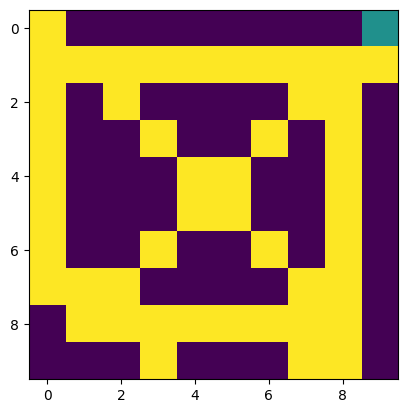

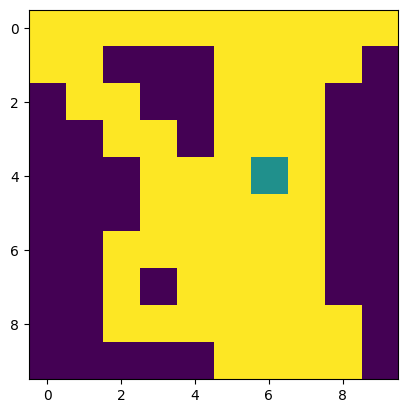

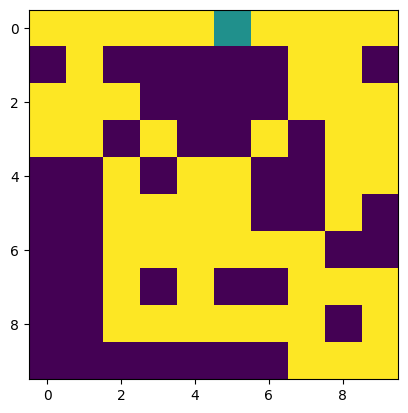

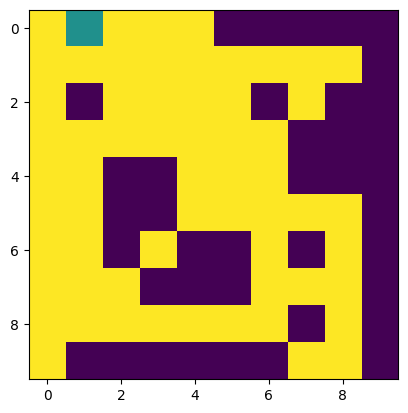

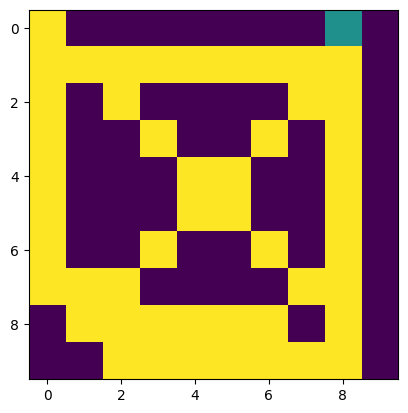

In [59]:
N_STEPS = 1_000_000
TEST_EPISODES = 5

# train & evaluate stable-baseline3 model
env = BlankFieldEnv()
model = PPO_Agent(env, path='./output/experiments/')
model.train(n_timestep=N_STEPS)

# evaluate
for episode_num in range(TEST_EPISODES):
    obs = env.reset()
    done = True
    steps = 0
    while True:
        action, hidden_state = model.predict(obs, start=done)
        obs, reward, done, observation = env.step(action.item())
        if done:
            plt.imshow(env.field)
            plt.show()
            break
        steps += 1

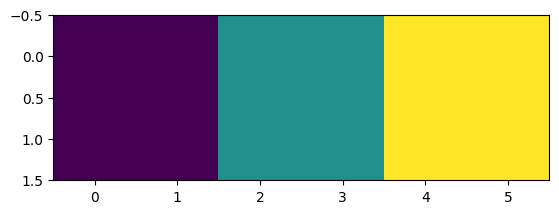

In [38]:
plt.imshow(np.array([[-1,-1,0,0,1,1],[-1,-1,0,0,1,1]]))